In [1]:
from glob import glob
from pathlib import Path

import cv2 
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm 

from keras.applications.mobilenet import preprocess_input
import tensorflow as tf
from tensorflow.keras.models import Model

from SNN.shared_nearest_neighbors import SNN
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, accuracy_score, precision_score, recall_score
from sklearn import preprocessing

from finder.utils import load_model, construct_dataset

plt.style.use('ggplot')

def parse(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image, label

def construct_dataset(fnames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((fnames, labels))
    dataset = dataset.map(parse, num_parallel_calls=4)
    # dataset = dataset.shuffle(len(fnames))
    dataset = dataset.batch(24)
    dataset = dataset.prefetch(1)
    return dataset

def embed(img):
    embeddings = model(img)
    normalized = preprocessing.normalize(embeddings, norm='l2')
    return normalized

In [2]:
# construct dataset
fnames = []
labels = []

root = './data'
brands = glob(f'{root}/*')

count = 0
for brand in brands:
    print(f"Adding {brand.split('/')[-1]} to dataset as label {count}")
    items = glob(f'{brand}/*')
    fnames += items
    labels += [count] * len(items)
    count += 1
assert len(fnames) == len(labels)

Adding 9703c845-7d31-4bf6-8146-917ca7bc1d39 to dataset as label 0
Adding 9683e268-78c6-45a5-827f-bf5c6584281f to dataset as label 1
Adding 0a2ac933-f473-49b1-baa7-3825696e2e7f to dataset as label 2
Adding e6e2f7a0-2671-4ba4-a069-956df1d2d1e9 to dataset as label 3
Adding 9706ed74-9fb0-4605-8c48-a5bb0691fa79 to dataset as label 4
Adding 9646a030-d132-4f9e-8862-8a8426eb4116 to dataset as label 5
Adding 9739d364-d821-4862-8f52-0faac775ee93 to dataset as label 6
Adding 0a0eb84b-a0ad-4da8-9325-6c66ac6d4e54 to dataset as label 7
Adding 9686d443-2afd-4c2e-8825-274964640549 to dataset as label 8
Adding fc5c1ee9-6594-4c35-b4f0-204809d3f940 to dataset as label 9
Adding 0e15fe74-8e2f-4db7-9722-41421594337c to dataset as label 10


In [3]:
# load pretrained model to compute embeddings
embedding_layer = 'feature_vector' 
model_path = Path("./model/0050-0.868171.hdf5")
m = tf.keras.models.load_model(model_path)
model = Model(inputs=m.input, outputs=m.get_layer(embedding_layer).output)

2022-02-27 14:57:04.283175: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# construct dataset
dataset = construct_dataset(fnames, labels)
train_data = np.vstack([embed(X) for X, y in dataset])
print(f'We have {train_data.shape[0]} samples with {train_data.shape[1]}-dim embeddings')

We have 493 samples with 1024-dim embeddings


## Part I - Visualize ground truth clusters

In [6]:
# compute similarity matrix so we can identify nearest neighbors through brute force
sim_matrix = pairwise_distances(train_data, metric='euclidean')
print(f'shape {sim_matrix.shape}')

shape (493, 493)


In [36]:
idx = 26
n_results = 50

indices = pd.Series(sim_matrix[idx]).sort_values(ascending=True).index.values[:n_results]  # first element is itself
results = np.take(train_data, indices, axis=0)  # neighbor embeddings

y_test = np.take(labels, indices)
y_test_encoded = (y_test == labels[idx]).astype(int)  # 1 represents same cluster as query image, 0 for everything else
print(f'{np.mean(y_test_encoded == 0) * 100}% of {n_results} nearest neighbors are false positives')

34.0% of 50 nearest neighbors are false positives


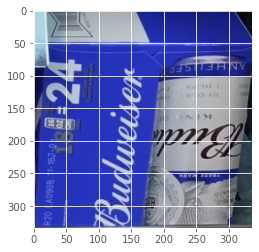

In [37]:
# visualize query image
query_path = fnames[idx]
plt.imshow(cv2.imread(query_path))

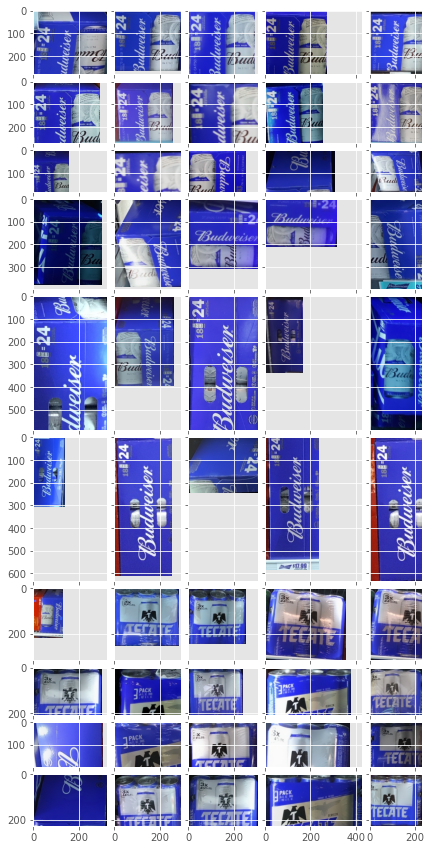

In [38]:
# visualize neighbors of query image
nearest_neighbors = list(np.take(np.array(fnames), indices))  # nearest neighbors

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 5), axes_pad=0.1,)

for ax, im in zip(grid, nearest_neighbors):
    ax.imshow(cv2.imread(im))

plt.show()

/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


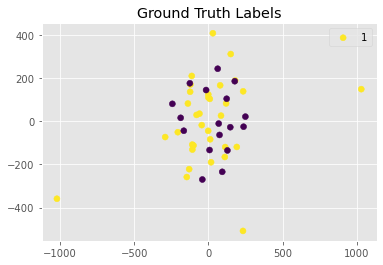

In [39]:
# ground truth cluster
t = TSNE(n_components=3)
projections = t.fit_transform(results)

plt.title(f'Ground Truth Labels')
plt.scatter(projections[:, 0], projections[:, 1], c=y_test_encoded)
plt.legend(y_test_encoded)

## Part 2: Density-Based Clustering
For lower dimensional data, we could use a density-based clustering approach for separation. However, we see that such an approach does not translate well for higher dimensional vectors. In fact, in most cases, we see zero separation between true and false positives.

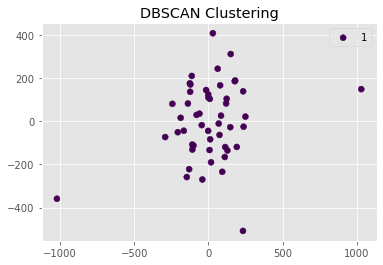

In [40]:
dbscan = DBSCAN(eps=0.1, min_samples=3, metric="euclidean")
dbscan.fit(results)
dbscan_labels = dbscan.labels_
pred = (dbscan_labels == dbscan_labels[0]).astype(int)  # first element is itself

plt.title(f'DBSCAN Clustering')
plt.scatter(projections[:,0], projections[:,1], c=pred)
plt.legend(pred)

In [41]:
acc = accuracy_score(y_test_encoded, pred)
precision = precision_score(y_test_encoded, pred)
recall = recall_score(y_test_encoded, pred)
print(f'Acc: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')

Acc: 0.66, Precision: 0.66, Recall: 1.00


## Part 3: Shared Neighbors Clustering
We use SNN to generate clusters that approximate ground truth clusters.

/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


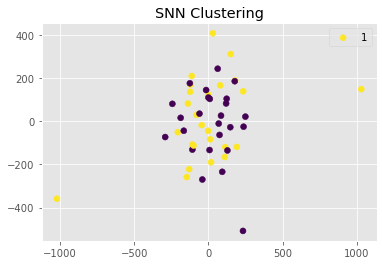

In [42]:
# plot points with cluster labels
snn = SNN(n_neighbors=3, eps=0.1, min_samples=5, metric="euclidean")  # tighter eps give better results
snn.fit(results)
snn_labels = snn.labels_
snn_pred = (snn_labels == snn_labels[0]).astype(int)  # first element is itself

plt.title(f'SNN Clustering')
plt.scatter(projections[:,0], projections[:,1], c=snn_pred)
plt.legend(snn_pred)

In [43]:
acc = accuracy_score(y_test_encoded, pred)
precision = precision_score(y_test_encoded, pred)
recall = recall_score(y_test_encoded, pred)
print(f'Acc: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')

Acc: 0.66, Precision: 0.66, Recall: 1.00
